### GRU

This notebook contains my implementation of GRU (Gated Recurrent Unit) following the [Paper](https://arxiv.org/pdf/1409.1259.pdf).

It is only for educational purposes and to strengthen my knowledge of how sequence models work, I will still use the embedding C approach.

In [4]:
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from typing import List, Tuple, Callable
from dataclasses import dataclass
import os
os.chdir("C:/Users/barto/Desktop/AI")
from models import plot_learning

%matplotlib inline

@dataclass
class NetworkConfig:
    c_embedding: int = 50 # C.shape --> 27 X 20
    vocab_size: int = 27
    batch_size: int = 1024
    input_weights: int = 1000# Wx.shape --> 20 x 1000; Wx @ x_t --> 512 x 1000
    tanh_gain: float = 5 / 3

#### Using dataset class defined for RNN

In [15]:
class RDataset(Dataset):

    def __init__(self, data: List[str], characters: List[str], max_len: int) -> None:
        self.words = data
        self.characters = characters
        self.max_word_len = max_len
        self.stoi = {char:val + 1 for val, char in enumerate(self.characters)}
        self.itos = {val:char for char, val in self.stoi.items()}
    
    def __len__(self):
        return len(self.words)
    
    def encode(self, word: str) -> torch.Tensor:
        return torch.tensor([self.stoi[ch] for ch in word], dtype=torch.long, requires_grad=False)
    
    def __getitem__(self, index):
        word = self.words[index]
        index = self.encode(word)
        #pad the examples
        x = torch.zeros(self.max_word_len + 1, dtype=torch.long, requires_grad=False)
        y = torch.zeros_like(x, requires_grad=False)
        x[1:len(index) + 1] = index
        y[:len(index)] = index
        y[len(index) + 1:] = -1
        return x, y


def _isascii(string: str) -> bool:
    for ch in string:
        if ord(ch) not in range(97, 123): return False
    return True

with open("../bigram/polish_names.txt", "r") as file:
    names = [name.rstrip("\n") for name in filter(lambda name: _isascii(name.rstrip("\n")), file.readlines())]

data = [name for name in names if len(name) in range(3, 16)]
perm = torch.randperm(len(data))
data = [data[index] for index in perm.tolist()]
characters, m_len = sorted(set(''.join(names))), len(max(data, key=lambda name: len(name)))

print(m_len, sorted(set(''.join(names))))

train_split = int(len(data) * 0.8)
val_split = int(len(data) * 0.9)
training_data = data[:train_split]
validation_data = data[train_split:val_split]
test_data = data[val_split:]

training_data = RDataset(training_data, characters, m_len)
# validation_data = RDataset(validation_data, characters, m_len)
# test_data = RDataset(test_data, characters, m_len)

training_loader = DataLoader(training_data, batch_size=NetworkConfig.batch_size)
validation_loader = DataLoader(RDataset(validation_data, characters, m_len), batch_size=NetworkConfig.batch_size)
test_loader = DataLoader(RDataset(test_data, characters, m_len), batch_size=NetworkConfig.batch_size)
training_data[10]

15 ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


(tensor([ 0,  1, 11, 19,  8,  1, 25,  0,  0,  0,  0,  0,  0,  0,  0,  0]),
 tensor([ 1, 11, 19,  8,  1, 25,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1]))

In [45]:
class GRU_cell(nn.Module):

    #input: (batch, c_embedding)
    def __init__(self ) -> None:
        super().__init__()
        self.Wrx = nn.Linear(NetworkConfig.c_embedding, NetworkConfig.input_weights)    #xt: (batch, 50) @ Wrx: (50, 1000)          -->(batch, 1000)
        self.Wrh = nn.Linear(NetworkConfig.input_weights, NetworkConfig.input_weights)  #h_t-1: (batch, 1000) @ Wrh: (1000, 1000)   -->(batch, 1000)
        nn.init.kaiming_normal_(self.Wrx.weight, nonlinearity='sigmoid')
        nn.init.kaiming_normal_(self.Wrh.weight, nonlinearity='sigmoid')
        self.Wzx = nn.Linear(NetworkConfig.c_embedding, NetworkConfig.input_weights)    #xt: (batch, 50) @ Wrx: (50, 1000)          -->(batch, 1000)
        self.Wzh = nn.Linear(NetworkConfig.input_weights, NetworkConfig.input_weights)  #h_t-1: (batch, 1000) @ Wrh: (1000, 1000)   -->(batch, 1000)
        nn.init.kaiming_normal_(self.Wzx.weight, nonlinearity='sigmoid')
        nn.init.kaiming_normal_(self.Wzh.weight, nonlinearity='sigmoid')
        self.Whx = nn.Linear(NetworkConfig.c_embedding, NetworkConfig.input_weights)    #xt: (batch, 50) @ Wrx: (50, 1000)          -->(batch, 1000)
        self.Whh = nn.Linear(NetworkConfig.input_weights, NetworkConfig.input_weights)  #h_t-1: (batch, 1000) @ Wrh: (1000, 1000)   -->(batch, 1000)
        torch.nn.init.kaiming_normal_(self.Whx.weight, nonlinearity='tanh')
        torch.nn.init.kaiming_normal_(self.Whh.weight, nonlinearity='tanh')
    
    def forward(self, xt: torch.Tensor, h_t_prev: torch.Tensor) -> torch.Tensor:
        r = torch.sigmoid(self.Wrx(xt) + self.Wrh(h_t_prev))
        z = torch.sigmoid(self.Wzx(xt) + self.Wzh(h_t_prev))
        h_candidate = torch.tanh(self.Whx(xt) + self.Whh(r * h_t_prev))
        return (1 - z) * h_candidate + z * h_t_prev

class GRU(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.embedding = nn.Embedding(NetworkConfig.vocab_size, NetworkConfig.c_embedding)
        self.h_0_param = nn.Parameter(torch.zeros(1, NetworkConfig.input_weights))
        self.gru_cell = GRU_cell()
        self.W_logits = nn.Linear(NetworkConfig.input_weights, NetworkConfig.vocab_size)
    
    def forward(self, X: torch.Tensor, Y: torch.Tensor) -> torch.Tensor:
        batch_size = X.shape[0]
        t = X.shape[1]

        hidden = []
        previous_activation = self.h_0_param.expand((batch_size, NetworkConfig.input_weights))
        for i in range(t):
            ht = self.gru_cell.forward(self.embedding(X[:, i]), previous_activation)
            hidden.append(ht)
            previous_activation = ht
        
        hidden = torch.stack(hidden, 1)
        logits = self.W_logits(hidden)
        loss =  F.cross_entropy(logits.view(-1, NetworkConfig.vocab_size), Y.view(-1), ignore_index=-1)

        return loss
    
    @torch.inference_mode()
    @staticmethod
    def validation_loop(model, data: DataLoader) -> torch.Tensor:
        v_loss: float = 0
        for i, (X, Y) in enumerate(data):
            X = X.to('cuda')
            Y = Y.to('cuda')
            loss = model.forward(X, Y)
            v_loss += loss.item()
        return v_loss / (i + 1)

In [66]:
gru = GRU()
optimizer = torch.optim.AdamW(gru.parameters(), lr=0.0001)
gru.to('cuda')

train_loss = []
val_loss = []

min_val_loss: float = 9999.9999
best_weights = gru.state_dict()
epoch_counter: int = 0

In [67]:
for i in range(50):
    t_loss: float = 0
    for j, (X, Y) in enumerate(training_loader):
        X = X.to('cuda')
        Y = Y.to('cuda')
        loss = gru.forward(X, Y)
        gru.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        t_loss += loss.item()
    train_loss.append(t_loss / (j + 1))

    if (v_loss := GRU.validation_loop(gru, validation_loader)) < min_val_loss:
        min_val_loss = v_loss
        best_weights = gru.state_dict()
    print("\r", end='')
    print(f"Epoch {epoch_counter + 1} | Train loss --> {t_loss / (j + 1):.4f} | Val loss --> {v_loss:.4f} |", end='', flush=True)
    epoch_counter += 1
    val_loss.append(v_loss)

Epoch 50 | Train loss --> 1.8356 | Val loss --> 2.0886 |

In [68]:
test_loss = GRU.validation_loop(gru, test_loader)
print(f"Test set loss --> {test_loss}")

Test set loss --> 2.0957622051239015


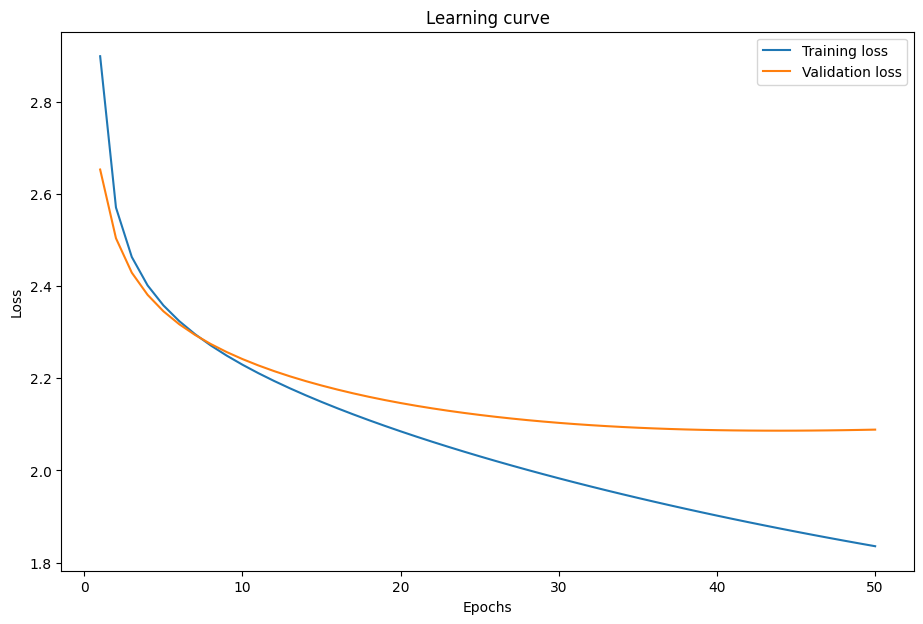

In [73]:
plot_learning("Learning curve", "Epochs", "Loss", range(1, len(val_loss) + 1), train_loss=train_loss, validation_loss=val_loss)

In [39]:
torch_gru = nn.GRU(batch_first=True,
                   input_size=NetworkConfig.c_embedding,
                   hidden_size=NetworkConfig.input_weights)
torch_embedding = nn.Embedding(NetworkConfig.vocab_size, NetworkConfig.c_embedding, device='cuda')
torch_logits_W = nn.Linear(NetworkConfig.input_weights, NetworkConfig.vocab_size, device='cuda')
optimizer = torch.optim.AdamW(torch_gru.parameters(), lr=0.0001)

torch_gru.to('cuda')

torch_train_loss = []
torch_val_loss = []

torch_min_val_loss: float = 9999.9999
torch_best_weights = gru.state_dict()
torch_epoch_counter: int = 0

In [40]:
@torch.inference_mode()
def validation_loop_torch_model(model, data: DataLoader) -> torch.Tensor:
    v_loss: float = 0
    for i, (X, Y) in enumerate(data):
        X = X.to('cuda')
        Y = Y.to('cuda')
        h_0 = torch.zeros((1, X.shape[0], NetworkConfig.input_weights), device='cuda')
        logits, hidden = model.forward(torch_embedding(X), h_0)
        loss = F.cross_entropy(torch_logits_W(logits).view(-1, NetworkConfig.vocab_size), Y.view(-1), ignore_index=-1) 
        v_loss += loss.item()
    return v_loss / (i + 1)

In [41]:
for i in range(50):
    torch_t_loss: float = 0
    for j, (X, Y) in enumerate(training_loader):
        X = X.to('cuda')
        Y = Y.to('cuda')
        h_0 = torch.zeros((1, X.shape[0], NetworkConfig.input_weights), device='cuda')
        torch_logits, hidden = torch_gru.forward(torch_embedding(X), h_0)
        torch_loss = F.cross_entropy(torch_logits_W(torch_logits).view(-1, NetworkConfig.vocab_size), Y.view(-1), ignore_index=-1) 
        torch_gru.zero_grad(set_to_none=True)
        torch_loss.backward()
        optimizer.step()
        torch_t_loss += torch_loss.item()
    torch_train_loss.append(torch_t_loss / (j + 1))

    if (torch_v_loss := validation_loop_torch_model(torch_gru, validation_loader)) < torch_min_val_loss:
        torch_min_val_loss = torch_v_loss
        torch_best_weights = torch_gru.state_dict()
    print("\r", end='')
    print(f"Epoch {torch_epoch_counter + 1} | Train loss --> {torch_t_loss / (j + 1):.4f} | Val loss --> {torch_v_loss:.4f} |", end='', flush=True)
    torch_epoch_counter += 1
    torch_val_loss.append(torch_v_loss)

Epoch 50 | Train loss --> 2.2087 | Val loss --> 2.2386 |

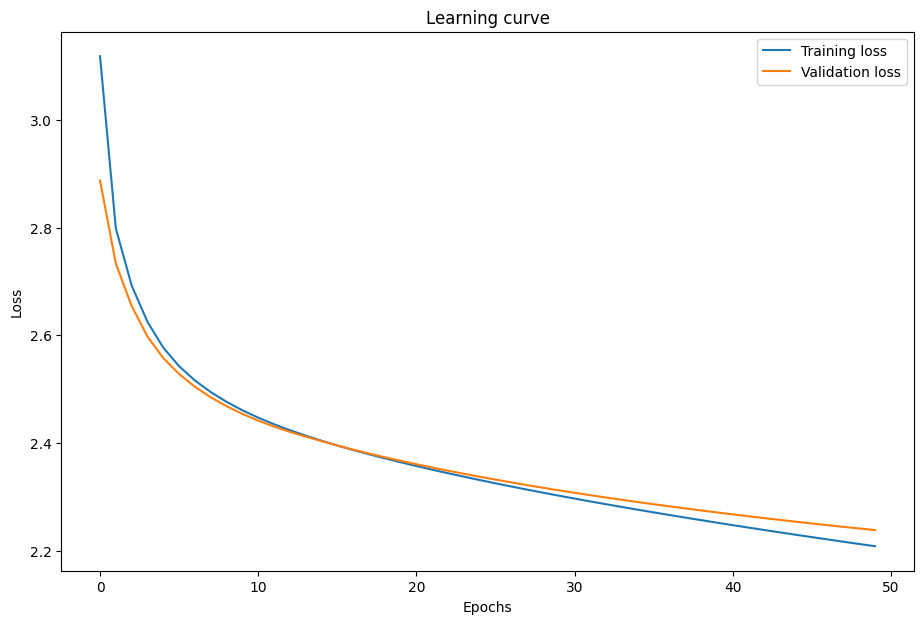

In [56]:
plot_learning("Learning curve", "Epochs", "Loss", range(len(torch_val_loss)), train_loss=torch_train_loss, validation_loss=torch_val_loss)